In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  8
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [2]:
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path_data = '../data/dataset/'
# path_data = '../data/augumented_dataset/'
path_train = path_data+'train/'
path_val = path_data+'test/'

num_l_train = len(os.listdir(path_train+'left'))
num_r_train = len(os.listdir(path_train+'right'))

num_l_val = len(os.listdir(path_val+'right'))
num_r_val = len(os.listdir(path_val+'left'))

total_train = num_l_train + num_r_train
total_val = num_l_val + num_r_val

In [4]:
# batch_size = 128
batch_size = 32
epochs = 10
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ
predict_image_generator = ImageDataGenerator(rescale=1./255) # 予測データのジェネレータ

In [6]:
train_data_gen = train_image_generator.flow_from_directory(directory=path_train,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2286 images belonging to 2 classes.


In [22]:
def train_data_gen2():
    while True:
        X1i = train_data_gen.next()
        X2i = train_data_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [7]:
val_data_gen = validation_image_generator.flow_from_directory(directory=path_val,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 764 images belonging to 2 classes.


In [23]:
def val_data_gen2():
    while True:
        X1i = val_data_data_gen.next()
        X2i = val_data_data_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [24]:
predict_data_gen = predict_image_generator.flow_from_directory(directory=path_data+'natural_img/',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=1636,
                                                               shuffle=False,
                                                              class_mode='categorical')

Found 1636 images belonging to 1 classes.


In [25]:
path_val

'../data/dataset/test/'

In [26]:
!ls ../data/dataset/natural/

ls: cannot access '../data/dataset/natural/': No such file or directory


In [29]:
input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 6))
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='avg')

ValueError: Shapes (7, 7, 6, 64) and (64, 3, 7, 7) are incompatible

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(1, activation='sigmoid'))


In [13]:
model = models.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [14]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.0256 - val_accuracy: 0.9918
Epoch 2/10
71/71 [==============================] - 3s 49ms/step - loss: 0.0173 - accuracy: 0.9929 - val_loss: 0.4623 - val_accuracy: 0.7989
Epoch 3/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0305 - accuracy: 0.9889 - val_loss: 0.0383 - val_accuracy: 0.9891
Epoch 4/10
71/71 [==============================] - 4s 51ms/step - loss: 0.0076 - accuracy: 0.9969 - val_loss: 0.0820 - val_accuracy: 0.9851
Epoch 5/10
71/71 [==============================] - 3s 49ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0510 - val_accuracy: 0.9891
Epoch 6/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.1068 - val_accuracy: 0.9606
Epoch 7/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0361 - accuracy: 0.9942 - val_loss: 3.9928 - val_accuracy: 0.9511
Epoch 8/10
71

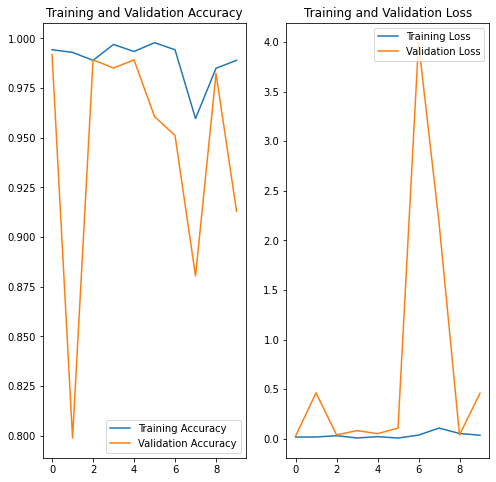

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [118]:
# os.mkdir('../data/weight')
model.save('../data/weight/resnet50.h5')


In [10]:
sample_pred_images, _ = next(predict_data_gen)

In [28]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

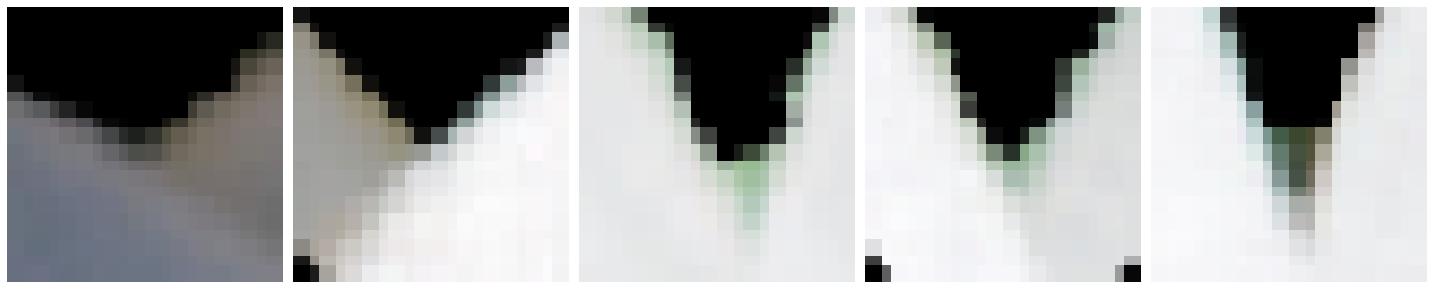

In [30]:
plotImages(sample_pred_images[5:10])

In [11]:
sample_pred_images.shape

(1636, 32, 32, 3)

In [12]:
list_ = sorted(os.listdir(path_data+'natural_img/natural'))[2:]
print(len(list_))
list_[:5]

1636


['0_0.png', '0_1.png', '0_2.png', '0_3.png', '0_4.png']

In [9]:
# import tensorflow as tf
model = tf.keras.models.load_model('../data/weight/resnet50.h5')

In [13]:
pred = model.predict(sample_pred_images, batch_size=None, verbose=0, steps=None) > 0.5

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/conv1_conv/Conv2D (defined at <ipython-input-13-a8e8ad7a19f8>:1) ]] [Op:__inference_predict_function_11098]

Function call stack:
predict_function


In [62]:
pred = np.hstack((list_, pred[:,0]))

In [63]:
pred.shape

(3272,)

In [64]:
pred = pred.reshape(2,-1)
pred.shape

(2, 1636)

In [70]:
pd.DataFrame(pred).T.to_csv('../data/pred_resnet50.csv', header=False, index=False)

In [106]:
from PIL import Image
for i, bool_ in zip(np.arange(len(pred)), pred):
    img = np.array(sample_pred_images[i]*255, np.uint8)
    if bool_:
        Image.fromarray(img).save('../data/dataset/pred/right/'+str(i)+'.png')
    else:
        Image.fromarray(img).save('../data/dataset/pred/left/'+str(i)+'.png')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [80]:
sample_train_images, _ = next(train_data_gen)

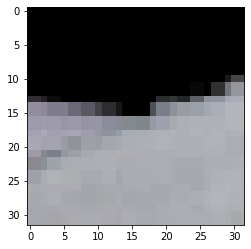

In [92]:
img = np.array(sample_train_images[1]*255, np.uint8)

plt.imshow(img)

In [85]:
pred = model.predict(sample_train_images, batch_size=None, verbose=0, steps=None) > 0.5

In [90]:
pred[:10]

array([[False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True]])